### Constructing a Network of Wikipedia Pages

To build a network out of the seed page and other relevant pages, let’s treat the
pages (and the respective Wikipedia subjects) as the network nodes and the links
between the pages as the network edges.

As a result, you will have a network of all pages related to complex networks and hopefully, you
will make some conclusions about it.

In [1]:
from operator import itemgetter
import networkx as nx
import wikipedia


In [2]:
 # constant SEED, the name of the starting page.
SEED = "Complex network".title()

To avoid the stardom syndrome, treat the known “star” pages as stop
words in information retrieval—in other words, ignore any links to them.
Constructing the black list of stop words, STOPS, is a matter of trial and error.

Currently there are twelve subjects on it; we can can add more when you come across
other “stars.” Also excluded pages whose names begin with "List of", because
they are simply lists of other subjects.

In [ ]:
STOPS = ("International Standard Serial Number",
"International Standard Book Number",
"National Diet Library",
"International Standard Name Identifier",
"International Standard Book Number (Identifier)",
"Pubmed Identifier", "Pubmed Central",
"Digital Object Identifier", "Arxiv",
"Proc Natl Acad Sci Usa", "Bibcode",
"Library Of Congress Control Number", "Jstor")

Below code fragment deals with setting up the snowballing process. A breadth-first search, or BFS , must remember which pages have been already processed and which have been discovered but not yet processed.

The former are stored in the set done_set; the latter, in the list todo_lst and set todo_set. You need two data structures for the unprocessed pages because you want to know whether
a page has been already recorded (an unordered lookup) and which page is the
next to be processed (an ordered lookup).

In [4]:
todo_lst = [(0, SEED)] # The SEED is in the layer 0
todo_set = set(SEED) # The SEED itself
done_set = set() # Nothing is done yet


Create empty directed graph that will later absorb discovered nodes and edges. We
choose a directed graph because the edges that represent HTML links are
naturally directed: a link from page A to page B does not imply a reciprocal link.

In [5]:
F = nx.DiGraph()


The same fragment primes the algorithm by extracting the first “to-do” item
(both its layer and page name) from the namesake list.

In [ ]:
layer, page = todo_lst[0]

The loop is programmed to collect all nodes that are at most two steps away from the seed node. They are reachable from the nodes in layer 1, and all those nodes will have been harvested when the loop terminates.

* Remove the name page of the current page from the todo_lst, and add it to the
set of processed pages. If the script encounters this page again, it will skip
over it.

* Attempt to download the selected page. If the attempt is unsuccessful (things
happen!), proceed to the next page from the “to-do” list.

* Evaluate each link. If the subject is not blacklisted and not a list itself, the
script adds an edge to the graph between the current node and the linked
page. If the script did not process the linked page before and it is not on the
“to-do” list, add it to the list and corresponding set. Note that the highlighted
code line is involved in the network construction—the only line in the script!

* Take the next page name from the “to-do” list. Hopefully, the list is not
empty. If it is—congratulations, you just downloaded the complete
Wikipedia!

In [6]:
while layer < 2:
    del todo_lst[0]
    done_set.add(page)
    print(layer, page) # Show progress
    try:
        wiki = wikipedia.page(page)
    except:
        layer, page = todo_lst[0]
        print("Could not load", page)
        continue
    for link in wiki.links:
        link = link.title()
        if link not in STOPS and not link.startswith("List Of"):
            if link not in todo_set and link not in done_set:
                todo_lst.append((layer + 1, link))
                todo_set.add(link)
            F.add_edge(page, link)
            layer, page = todo_lst[0]
print("{} nodes, {} edges".format(len(F), nx.number_of_edges(F)))
# 11597 nodes, 21331 edges

0 Complex Network
1 Adjacency List
171 nodes, 178 edges


Eliminate Duplicates

Start removing selfloops (pages referring to themselves). The loops don’t change
the network properties but affect the correctness of duplicate node elimination.

In [8]:
# F.remove_edges_from(F.selfloop_edges())
loops = nx.selfloop_edges(F)
print(loops)
F.remove_edges_from(loops)

<generator object selfloop_edges.<locals>.<genexpr> at 0x000001B85AE95AC8>


Now, you need a list of at least some duplicate nodes. You can build it by
looking at each node in F and checking if a node with the same name, but with
an s at the end, is also in F. Pass each pair of duplicated node names to the
function nx.contracted_nodes(F,u,v) that merges node v into node u in the graph F.
The function reassigns all edges previously incident to v, to u. If you don’t pass
the option self_loops=False, the function converts an edge from v to u (if any) to a
selfloop.

In [9]:
duplicates = [(node, node + "s") for node in F if node + "s" in F]
for dup in duplicates:
    F = nx.contracted_nodes(F, *dup, self_loops=False)
duplicates = [(x, y) for x, y
                    in [(node, node.replace("-", " ")) for node in F]
                            if x != y and y in F]
for dup in duplicates:
    F = nx.contracted_nodes(F, *dup, self_loops=False)

nx.set_node_attributes(F, "contraction", 0)

In [15]:
len(F.edges())


175

In [14]:
len(F.nodes())


167

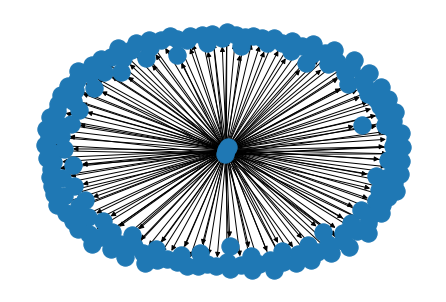

In [11]:
nx.draw(F)

In [25]:
for node, deg in F.degree():
    print(node,deg)

Complex Network 2
Adjacency List 134
Adjacency Matrix 42
Agent-Based Model 1
Albert-László Barabási 1
Arxiv (Identifier) 1
Artificial Neural Network 1
Assortativity 1
Autonomous System (Internet) 1
Balance Theory 1
Barabási–Albert Model 1
Bianconi–Barabási Model 1
Bibcode (Identifier) 1
Biological Network 1
Biology 1
Bipartite Graph 1
Blockmodeling 1
Boolean Network 1
Branching Process 1
Centrality 1
Climate 1
Climate Networks 1
Clique (Graph Theory) 1
Clustering Coefficient 1
Combinatorial Optimization 1
Community Structure 1
Complete Graph 1
Complex Adaptive System 1
Complex Contagion 1
Complex Systems 1
Computer Network 1
Computer Science 2
Connected Component (Graph Theory) 1
Connectome 1
Cut (Graph Theory) 1
Cycle (Graph Theory) 1
Degree (Graph Theory) 2
Degree Distribution 1
Dependency Network 1
Directed Graph 1
Distance (Graph Theory) 1
Doi (Identifier) 1
Dual-Phase Evolution 1
Duncan J. Watts 1
Dynamic Network Analysis 1
Edge (Graph Theory) 1
Efficiency (Network Science) 1
Entr

Truncate the Network

For now, let’s concentrate on a node indegree—the number of edges directed into the
node. (In the same spirit, the number of edges directed out of the node is called
outdegree.) The indegree of a node equals the number of HTML links pointing
to the respective page. If a page has a lot of links to it, the topic of the page must
be significant.

* If a node has one incoming edge, then removing the node affects the
outdegree of some other node, but you do not care about outdegrees.

* If a node has one outgoing edge (and the node is not the seed), you could
not have found it, at least not with snowballing.

Start by calling F.degree. The method returns a dictionary with nodes as keys and
degree as values.

Function nx.subgraph(F, core) collects all core nodes from F and all edges
connecting them and builds a new graph G—a subgraph of F. (Naturally, F has a
lot of different subgraphs. Even F itself is a subgraph of F.) G is a truncated
version of F. Write it to a GraphML file so that you don’t have to rebuild it if you
need it later again.

In [26]:
core = [node for node, deg in F.degree() if deg >= 2]
G = nx.subgraph(F, core)
print("{} nodes, {} edges".format(len(G), nx.number_of_edges(G)))
# 2995 nodes, 11817 edges
nx.write_graphml(G, "./data/cna.graphml")

11 nodes, 19 edges


In [28]:
top_indegree = sorted(G.in_degree(),
reverse=True, key=itemgetter(1))[:100]
print("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))

2 Degree (Graph Theory)
2 Graph (Abstract Data Type)
2 Computer Science
2 Graph Drawing
2 Graph (Discrete Mathematics)
2 Vertex (Graph Theory)
2 Incidence Matrix
2 Isbn (Identifier)
1 Adjacency List
1 Complex Network
1 Adjacency Matrix
